Here we gonna run experiment with Transformer-CycleGAN. It gonna be cooool!

First of all, we should use two transformers: src->trg and trg->src. We gonna sample from them and build cyclic loss:
* take two unrelated examples, $x$ from `src` and $y$ from `trg`, translate them: $x \to \hat{y}, y \to \hat{x}$ and then translate them back. The result should be identical to original values: $x \to \hat{y} \to x$ and $y \to \hat{x} \to y$.

We should also try:
* using single Transformer for src->trg and trg->src translation (it is capable to do it in supervised regime)
* adding noise
* adding noise and learning as DAE
* using learnt word embeddings
* using strong discriminator (Transformer or RNN)
* using shared encoder/decoder
* using single discriminator
* adding normalization between two generators
* learning short sentences first and gradually increasing length (cause our time dependencies are way too long)

In [1]:
%load_ext autoreload
%autoreload 2
# %aimport

In [2]:
import sys; sys.path += ['..', '../src']

In [3]:
import os
from src.vocab import Vocab

DATA_PATH = '../data/generated'
max_len = 50 # Processing long sentences is slow

train_src_path = os.path.join(DATA_PATH, 'train.en.tok.bpe')
train_trg_path = os.path.join(DATA_PATH, 'train.fr.tok.bpe')
val_src_path = os.path.join(DATA_PATH, 'val.en.tok.bpe')
val_trg_path = os.path.join(DATA_PATH, 'val.fr.tok.bpe')

train_src = open(train_src_path, 'r', encoding='utf-8').read().splitlines()
train_trg = open(train_trg_path, 'r', encoding='utf-8').read().splitlines()
val_src = open(val_src_path, 'r', encoding='utf-8').read().splitlines()
val_trg = open(val_trg_path, 'r', encoding='utf-8').read().splitlines()

# Simple preprocessing: crop lines and remove empty sentences
train_src = [s.split()[:max_len-2] for s in train_src if len(s) != 0]
train_trg = [s.split()[:max_len-2] for s in train_trg if len(s) != 0]
val_src = [s.split()[:max_len-2] for s in val_src if len(s) != 0]
val_trg = [s.split()[:max_len-2] for s in val_trg if len(s) != 0]

vocab_src = Vocab.from_file(os.path.join(DATA_PATH, 'vocab.en'))
vocab_trg = Vocab.from_file(os.path.join(DATA_PATH, 'vocab.fr'))

train_src_idx = [[vocab_src.token2id.get(t, vocab_src.unk) for t in s] for s in train_src]
train_trg_idx = [[vocab_trg.token2id.get(t, vocab_trg.unk) for t in s] for s in train_trg]
val_src_idx = [[vocab_src.token2id.get(t, vocab_src.unk) for t in s] for s in val_src]
val_trg_idx = [[vocab_trg.token2id.get(t, vocab_trg.unk) for t in s] for s in val_trg]

In [4]:
import os

from src.transformer.models import Transformer
from src.utils.data_utils import load_embeddings, init_emb_matrix
from src.models import TransformerClassifier

# transformer_kwargs = {
#     'n_layers': 4,
#     'n_head': 4,
#     'd_word_vec': 256,
#     'd_model': 256,
#     'd_inner_hid': 1024,
#     'd_k': 64,
#     'd_v': 64
# }
transformer_kwargs = {
    'n_layers': 2,
    'n_head': 2,
    'd_word_vec': 128,
    'd_model': 128,
    'd_inner_hid': 256,
    'd_k': 32,
    'd_v': 32
}

# transformer_src_to_trg = Transformer(len(vocab_src), len(vocab_trg), max_len)
transformer_src_to_trg = Transformer(len(vocab_src), len(vocab_trg), max_len, **transformer_kwargs)
discriminator_trg = TransformerClassifier(len(vocab_trg), 2, max_len, **transformer_kwargs)

# transformer_trg_to_src = Transformer(len(vocab_trg), len(vocab_src), max_len)
transformer_trg_to_src = Transformer(len(vocab_trg), len(vocab_src), max_len, **transformer_kwargs)
discriminator_src = TransformerClassifier(len(vocab_src), 2, max_len, **transformer_kwargs)

# Initializing transformer encoder and decoder with embeddings
# embeddings_src = load_embeddings('../trained_models/europarl.en.tok.bpe_cbow.vec')
# embeddings_trg = load_embeddings('../trained_models/europarl.fr.tok.bpe_cbow.vec')

# init_emb_matrix(transformer_src_to_trg.encoder.src_word_emb.weight.data, embeddings_src, vocab_src.token2id)
# init_emb_matrix(transformer_src_to_trg.decoder.tgt_word_emb.weight.data, embeddings_trg, vocab_trg.token2id)

# init_emb_matrix(transformer_trg_to_src.encoder.src_word_emb.weight.data, embeddings_trg, vocab_trg.token2id)
# init_emb_matrix(transformer_trg_to_src.decoder.tgt_word_emb.weight.data, embeddings_src, vocab_src.token2id)

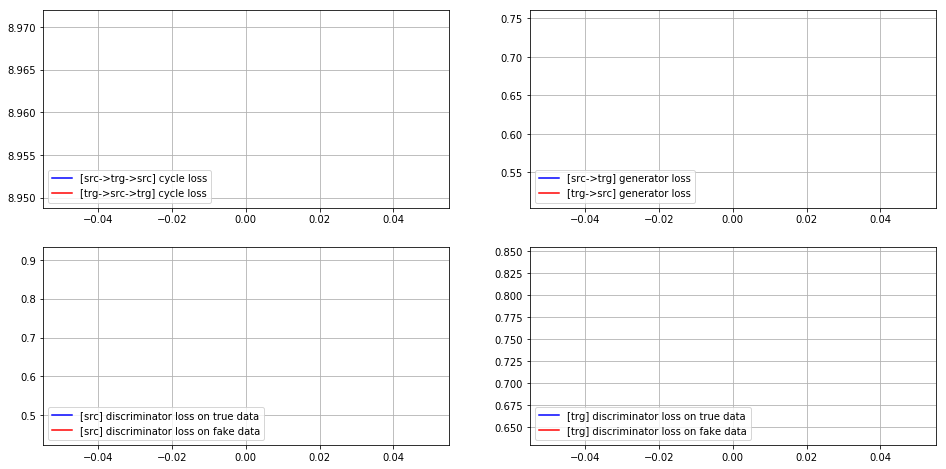

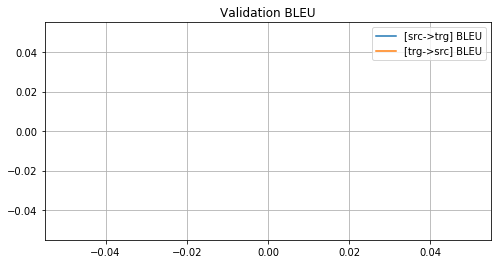

In [10]:
%matplotlib inline

import torch
import torch.nn as nn
from torch.optim import Adam

from src.utils.batcher import Batcher
import src.transformer.constants as constants
from src.cycle_trainer import CycleTrainer


use_cuda = torch.cuda.is_available()
training_data = Batcher(train_src_idx, train_trg_idx, vocab_src.token2id,
                        vocab_trg.token2id, batch_size=2, shuffle=False)

val_data = Batcher(val_src_idx[:2], val_trg_idx[:2], vocab_src.token2id,
                   vocab_trg.token2id, batch_size=2, shuffle=False)
    

def reconstruction_criterion(vocab_size):
    ''' With PAD token zero weight '''
    weight = torch.ones(vocab_size)
    weight[constants.PAD] = 0

    return nn.CrossEntropyLoss(weight)


adv_criterion = nn.BCEWithLogitsLoss()
reconstruct_src_criterion = reconstruction_criterion(len(vocab_src))
reconstruct_trg_criterion = reconstruction_criterion(len(vocab_trg))

transformer_src_to_trg_optimizer = Adam(transformer_src_to_trg.get_trainable_parameters(), lr=1e-4)
transformer_trg_to_src_optimizer = Adam(transformer_trg_to_src.get_trainable_parameters(), lr=1e-4)
discriminator_src_optimizer = Adam(discriminator_src.get_trainable_parameters(), lr=1e-4)
discriminator_trg_optimizer = Adam(discriminator_trg.get_trainable_parameters(), lr=1e-4)

training_config = {
    'max_num_epochs': 10
}

trainer = CycleTrainer(transformer_src_to_trg, transformer_trg_to_src,
                 discriminator_src, discriminator_trg, vocab_src, vocab_trg,
                 transformer_src_to_trg_optimizer, transformer_trg_to_src_optimizer,
                 discriminator_src_optimizer, discriminator_trg_optimizer,
                 reconstruct_src_criterion, reconstruct_trg_criterion, adv_criterion, training_config)

trainer.run_training(training_data, val_data, plot_every=10, val_bleu_every=100)